# Лабораторная работа №2

* студент: Шаповалов И.О.
* группа: РЛ1-93


## ФМ2 Общий расчет

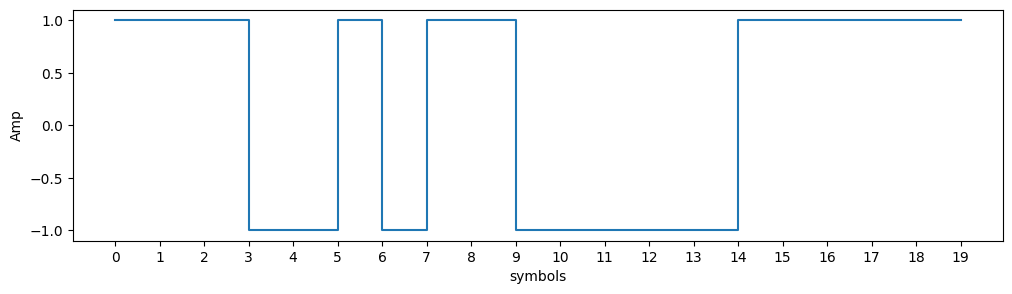

In [885]:
import numpy as np
from numpy.fft import fft, fftshift
import matplotlib.pyplot as plt

def get_telegraph_signal(h = 1.0, seed = 7, number = 1000):
    data = np.random.default_rng(seed).random(number)
    symOne = 1*(data >= 0.5)
    symZero = -1*(data < 0.5)
    return (h*(symOne + symZero), range(len(data)))


x, numbers = get_telegraph_signal()
fig1,ax1 = plt.subplots(figsize = (12, 3))
ax1.step(numbers[:20], x[:20], where='post')
ax1.set_xlabel('symbols')
ax1.set_ylabel('Amp')
ax1.set_xticks(np.arange(0,20));  # Задаем шаг сетки x


Number of samples per simbos is  50


Text(0, 0.5, 'Amp')

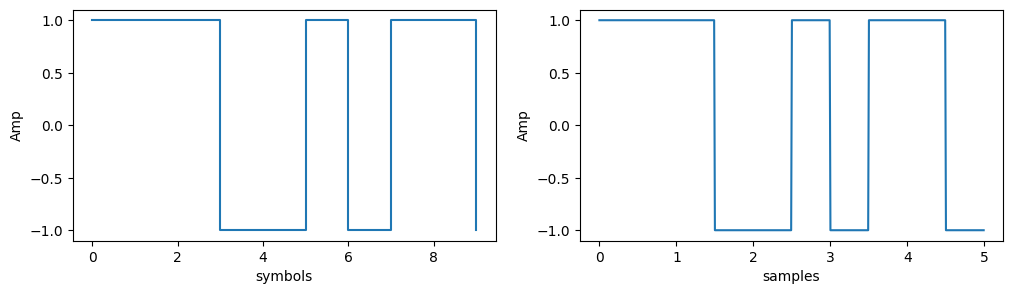

In [886]:
f0 = 5*2 #TODO
fs = 10*f0 

def to_samples(x, f0 = f0, nperiods = 5):
    fs = 10*f0
    dt = 1/fs
    T = nperiods/f0
    ns = int(fs*T)
    print('Number of samples per simbos is ', ns)
    xs = np.array([np.ones(ns)*i for i in x])
    xs = np.reshape(xs, -1)
    t = np.arange(0, dt*len(xs), dt)
    return (xs, t, T, dt)

def to_fm2(x,t,h,f0 = f0, U0 = 1.0, ph0 = 0):
    return U0/h*x*np.cos(2*np.pi*f0*t + ph0)


(s, t, T, dt) = to_samples(x, f0 = f0)
s_fm2 = to_fm2(s, t, h = 1, f0 = f0)


fig2,ax2 = plt.subplots(1, 2, figsize=(12, 3))
ax2[0].step(numbers[:10], x[:10], where='post')
ax2[0].set_xlabel('symbols')
ax2[0].set_ylabel('Amp')
ax2[1].plot(t[:500], s[:500])
ax2[1].set_xlabel('samples')
ax2[1].set_ylabel('Amp')

In [887]:
#Моделирование гауссовского канала связи
def wgn_channel(x, power = 0, a = 1, interf_sig = 0):
    u = 10**(0.05*power)
    n = len(x)
    noise = u*np.random.normal(loc = 0,scale= 1., size = n) #отсчёты БГШ
    print("Noise power is ", np.var(noise))
    return a*x + noise + interf_sig

Noise power is  1.0080307293934236


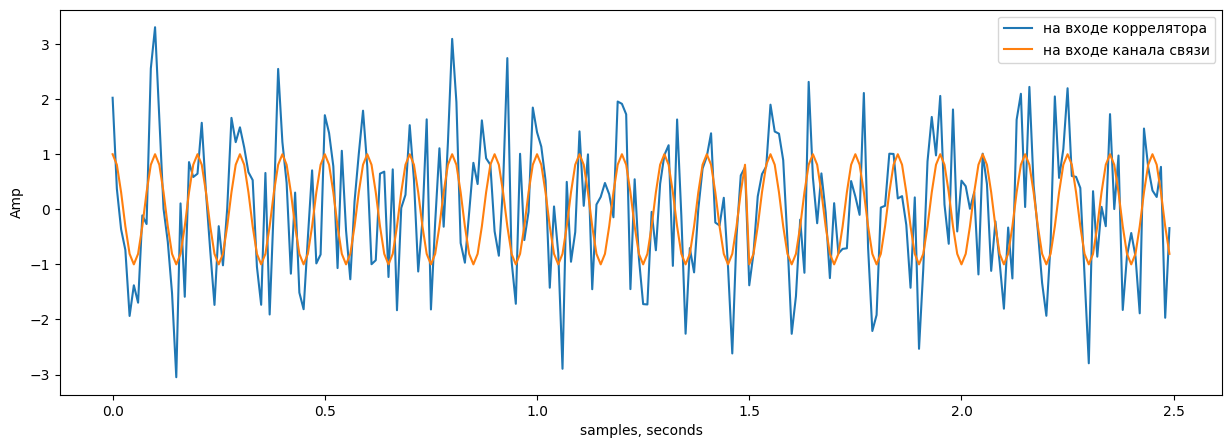

In [888]:
u = wgn_channel(s_fm2,0)

fig1,ax1 = plt.subplots(figsize = (15, 5))
ax1.plot(t[:250], u[:250], label= 'на входе коррелятора')
ax1.plot(t[:250], s_fm2[:250], label= 'на входе канала связи')
ax1.set_xlabel('samples, seconds')
ax1.set_ylabel('Amp')
ax1.legend();


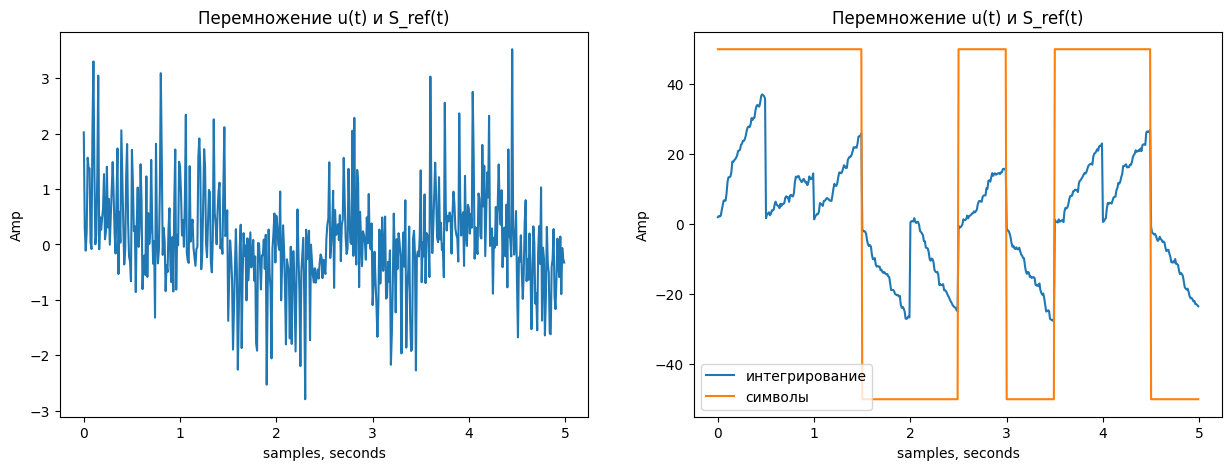

In [889]:
def corr_receiver(x, t, T, f0 = f0, phi = 0):
    dt = t[1] - t[0]
    ns = int(T/dt)
    u = x.reshape(-1, ns)
    s_ref = np.cos(2*np.pi*f0*t + phi).reshape(-1, ns)
    # s_ref = s_fm2.reshape(-1, ns)
    us = np.multiply(s_ref, u)
    int_us = np.cumsum(us, axis = 1)
    return(int_us.reshape(-1), us.reshape(-1), ns)


(q, us, n) = corr_receiver(u, t, T)

fig2,ax2 = plt.subplots(1, 2, figsize=(15, 5))
ax2[0].plot(t[:500], us[:500], label = 'перемножение')
ax2[0].set_xlabel('samples, seconds')
ax2[0].set_ylabel('Amp')
ax2[0].set_title('Перемножение u(t) и S_ref(t)')
ax2[1].plot(t[:500], q[:500], label= 'интегрирование')
ax2[1].set_xlabel('samples, seconds')
ax2[1].set_ylabel('Amp')
ax2[1].set_title('Перемножение u(t) и S_ref(t)')
ax2[1].plot(t[:500], n*s[:500], label= 'символы')
ax2[1].legend();

In [890]:
#Оценка помехоустойчивости системы передачи информации
def calc_err(x, orig, threshold = 0):
    q1 = x[:,-1]
    nsamples = len(q1)
    s1 = q1 > threshold
    orig = orig > 0
    errors = np.logical_xor(s1, orig)
    return np.sum(errors)/nsamples

#отправляем двум массив
biterr = calc_err(q.reshape(-1,n),x)
print('biterror is ', biterr)

biterror is  0.0


In [891]:
#исследование помехоустойчивости системы передачи информации
Ps = np.var(s_fm2); Es = Ps*T; Pn = np.var(u - s_fm2); N0 = Pn*dt
print('avg signal power is %5.2f and signal energy is %5.2f' %(Ps, Es))
print('noise power is %5.4f which means N0 is %5.4f' %(Pn, N0))
print("before corr-receiver E/N0 ratio is %5.2f and after corr-receiver 2E/N0 is %5.2f" %(Es/N0, 2*Es/N0))

noise_pwr_db = np.linspace(-3, 20, 25)
noise_pwr = 10**(0.1*noise_pwr_db)
h2 = Es/(noise_pwr*dt)



#теоретическая зависимость помехоустойчивости ФМ2
from scipy.stats import norm
Perr_fm2 = 1-norm.cdf(np.sqrt(2*h2))

def monte_carlo(Pn):
    Perr = []
    for n_db in Pn:
        u = wgn_channel(s_fm2,n_db)
        (q,us,n) = corr_receiver(u,t,T)
        Perr.append(calc_err(q.reshape(-1,n),x))
    return np.array(Perr)

Perr_fm2_exp = monte_carlo(noise_pwr_db)

avg signal power is  0.50 and signal energy is  0.25
noise power is 1.0080 which means N0 is 0.0101
before corr-receiver E/N0 ratio is 24.80 and after corr-receiver 2E/N0 is 49.60
Noise power is  0.49779221646734256
Noise power is  0.6306367149730184
Noise power is  0.774042232281375
Noise power is  0.9856595076014776
Noise power is  1.222976824152455
Noise power is  1.5236287493713412
Noise power is  1.8606639501103743
Noise power is  2.380999807841169
Noise power is  2.930005080829758
Noise power is  3.6627487350623538
Noise power is  4.537909189429428
Noise power is  5.65552785593051
Noise power is  7.043402481030781
Noise power is  8.823948480016426
Noise power is  11.163010329387015
Noise power is  13.69983812246403
Noise power is  17.20647133003495
Noise power is  21.251303068849648
Noise power is  26.543557804082482
Noise power is  33.32647604317495
Noise power is  41.490420955765316
Noise power is  51.46931969770767
Noise power is  64.44511415796148
Noise power is  80.316906939

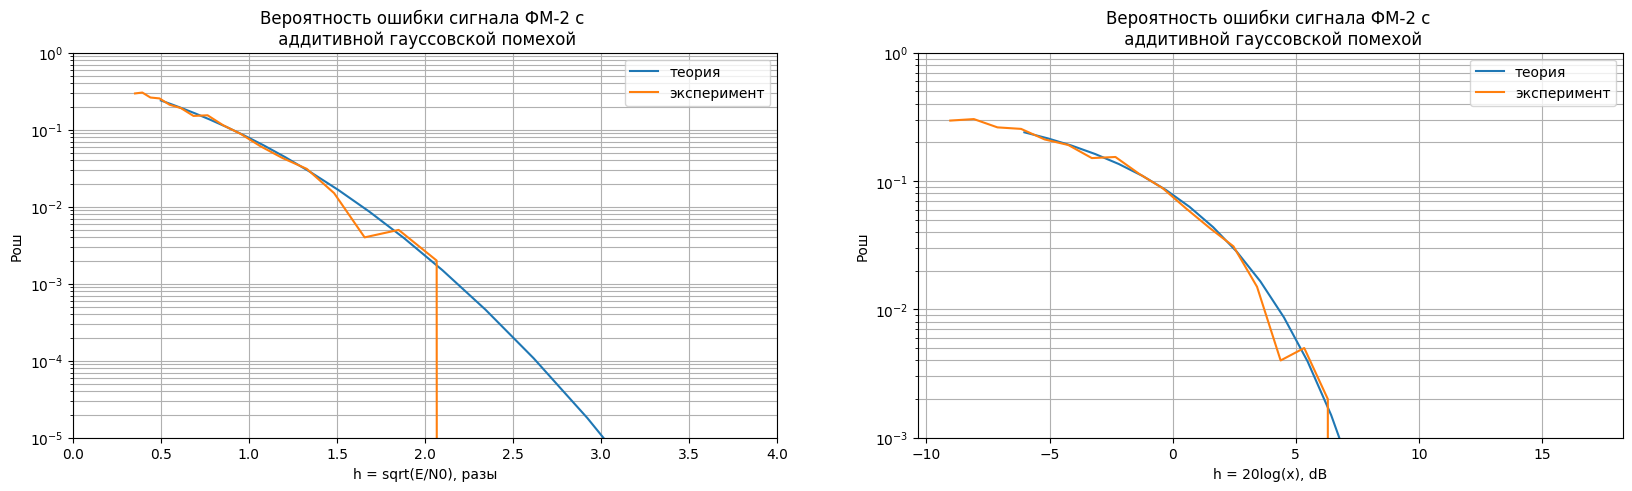

In [892]:
fig3, ax3 = plt.subplots(1, 2, figsize = (20, 5))
ax3[0].semilogy(np.sqrt(h2),Perr_fm2, label='теория')
ax3[0].semilogy(np.sqrt(0.5*h2),Perr_fm2_exp, label='эксперимент')

ax3[0].set_title('Вероятность ошибки сигнала ФМ-2 с \n аддитивной гауссовской помехой')
ax3[0].set_xlabel('h = sqrt(E/N0), разы')
ax3[0].set_ylabel('Pош')
ax3[0].grid(True, which = 'both', axis = 'both')
ax3[0].set_ylim(1e-5,1)
ax3[0].set_xlim(0,4)
ax3[0].legend()

ax3[1].semilogy(20*np.log10(np.sqrt(h2)),Perr_fm2, label='теория')
ax3[1].semilogy(20*np.log10(np.sqrt(0.5*h2)),Perr_fm2_exp, label='эксперимент')

ax3[1].set_xlabel('h = 20log(x), dB')
ax3[1].set_title('Вероятность ошибки сигнала ФМ-2 с \n аддитивной гауссовской помехой')
ax3[1].set_ylabel('Pош')
ax3[1].grid(True, which = 'both', axis = 'both')
ax3[1].set_ylim(1e-3, 1)
ax3[1].legend();


#### 9 Пункт

Модифицируем гауссовский канал связи добавив в него гармоническую помеху на той же частоте и половинной мощности, что и полезный сигнал, и начальной фазой 30.

In [893]:
s_fm2 = to_fm2(s, t, h = 1)
s_fm2_interf = to_fm2(1, t, h = 1, U0 = 1/np.sqrt(2), ph0 = np.radians(30))


Noise power is  1.0045066352816339


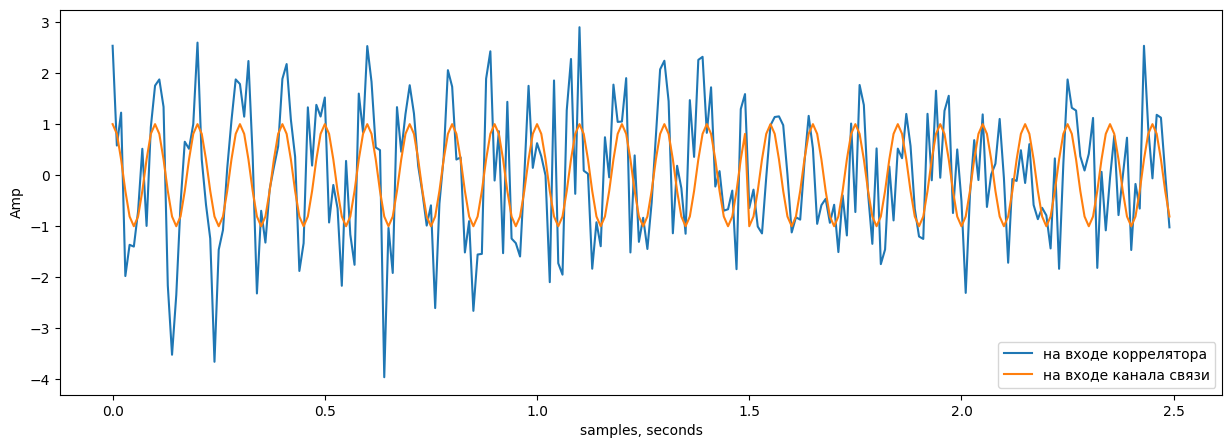

In [894]:
u2 = wgn_channel(s_fm2, interf_sig = s_fm2_interf)

fig4,ax4 = plt.subplots(figsize = (15, 5))
ax4.plot(t[:250], u2[:250], label= 'на входе коррелятора')
ax4.plot(t[:250], s_fm2[:250], label= 'на входе канала связи')
ax4.set_xlabel('samples, seconds')
ax4.set_ylabel('Amp')
ax4.legend();

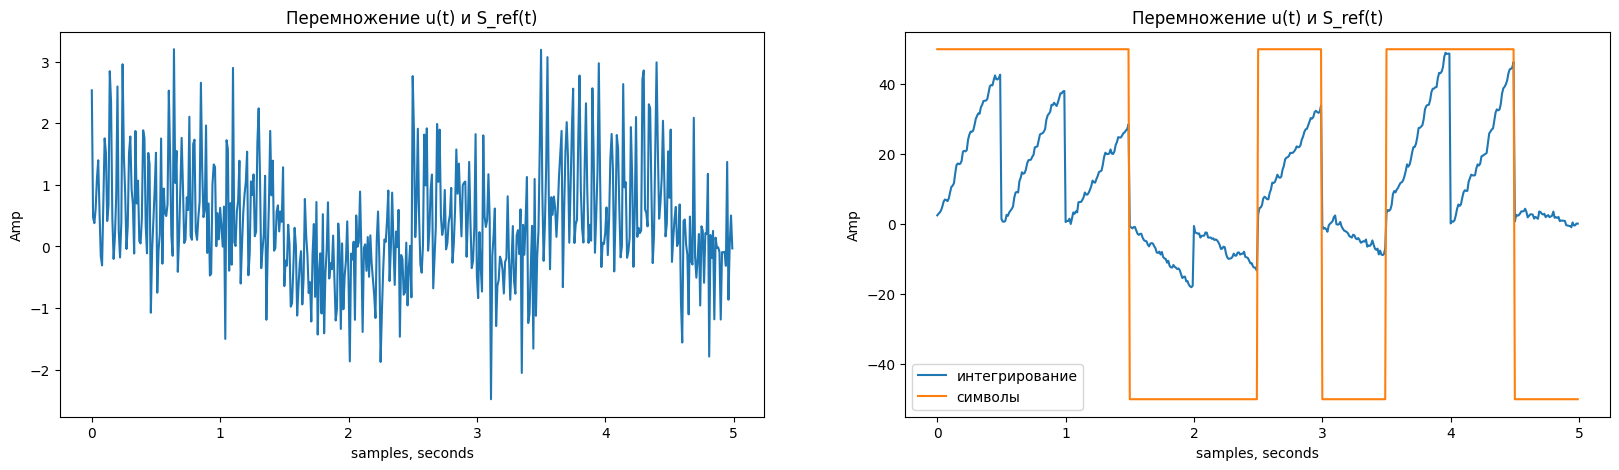

In [895]:
(q2, us2, n2) = corr_receiver(u2, t, T)

fig5,ax5 = plt.subplots(1, 2, figsize=(20, 5))
ax5[0].plot(t[:500], us2[:500], label = 'перемножение')
ax5[0].set_xlabel('samples, seconds')
ax5[0].set_ylabel('Amp')
ax5[0].set_title('Перемножение u(t) и S_ref(t)')
ax5[1].plot(t[:500], q2[:500], label= 'интегрирование')
ax5[1].set_xlabel('samples, seconds')
ax5[1].set_ylabel('Amp')
ax5[1].set_title('Перемножение u(t) и S_ref(t)')
ax5[1].plot(t[:500], n2*s[:500], label= 'символы')
ax5[1].legend();

In [896]:
biterr = calc_err(q2.reshape(-1,n), x)
print('biterror with signal(phi=30) is ', biterr)

biterror with signal(phi=30) is  0.012


In [897]:
Pn = np.var(u2 - s_fm2); N0 = Pn*dt
print('avg signal power is %5.2f and signal energy is %5.2f' %(Ps,Es))
print('noise power is %5.4f which means N0 is %5.4f' %(Pn,N0))
print("before corr-receiver E/N0 ratio is %5.2f and after corr-receiver 2E/N0 is %5.2f" %(Es/N0, 2*Es/N0))

h2 = Es/(noise_pwr*dt)

def monte_carlo_u(Pn):
    Perr = []
    for n_db in Pn:
        u2 = wgn_channel(s_fm2, interf_sig = s_fm2_interf, power = n_db)
        (q, us, n) = corr_receiver(u2, t, T)
        Perr.append(calc_err(q.reshape(-1,n), x))
    return np.array(Perr)

Perr_fm2 = (1/2*(1-norm.cdf(np.sqrt(2*h2)*(1 - np.sqrt(2)/2*np.cos(np.radians(30))))) + 
            1/2*(1-norm.cdf(np.sqrt(2*h2)*(1 + np.sqrt(2)/2*np.cos(np.radians(30)))))  )

Perr_fm2_exp = monte_carlo_u(noise_pwr_db)

avg signal power is  0.50 and signal energy is  0.25
noise power is 1.2481 which means N0 is 0.0125
before corr-receiver E/N0 ratio is 20.03 and after corr-receiver 2E/N0 is 40.06
Noise power is  0.5001185898959623
Noise power is  0.621095226992556
Noise power is  0.7871309057310175
Noise power is  0.9651534713477378
Noise power is  1.2168471123146394
Noise power is  1.4874673015973738
Noise power is  1.896677690435027
Noise power is  2.377417996016252
Noise power is  2.934638868503228
Noise power is  3.644256428175423
Noise power is  4.495899897137818
Noise power is  5.635045008563195
Noise power is  7.068523969034119
Noise power is  8.80235275380125
Noise power is  10.929273469222835
Noise power is  13.652801433493472
Noise power is  17.234031099213645
Noise power is  21.720606108030818
Noise power is  26.5306838731961
Noise power is  33.6021077267267
Noise power is  41.78512899338306
Noise power is  51.64858512532725
Noise power is  64.34116029359691
Noise power is  80.4618795343622

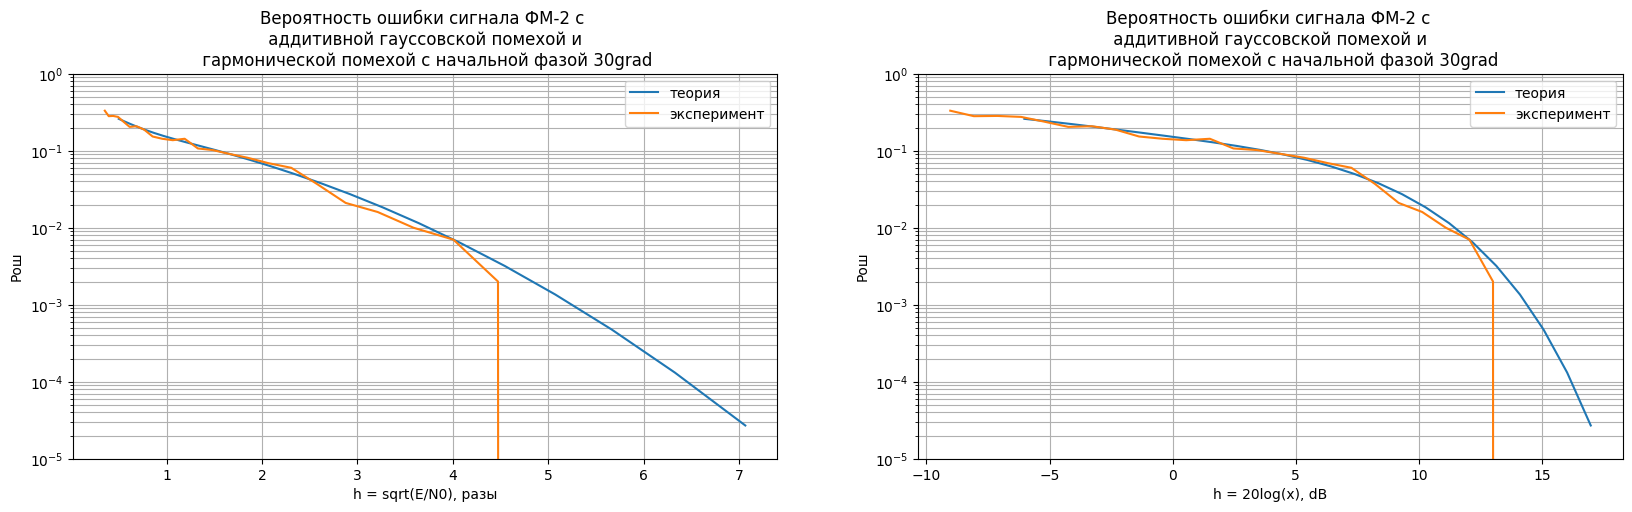

In [898]:
fig6, ax6 = plt.subplots(1, 2, figsize = (20, 5))

ax6[0].semilogy(np.sqrt(h2), Perr_fm2, label='теория')
ax6[0].semilogy(np.sqrt(0.5*h2), Perr_fm2_exp, label='эксперимент')

ax6[0].set_xlabel('h = sqrt(E/N0), разы')
ax6[0].set_ylabel('Pош')
ax6[0].grid(True, which = 'both', axis = 'both')
ax6[0].set_ylim(1e-5,1)
ax6[0].legend()
ax6[0].set_title('Вероятность ошибки сигнала ФМ-2 с \n аддитивной гауссовской помехой и \n гармонической помехой с начальной фазой 30grad')
ax6[1].set_title('Вероятность ошибки сигнала ФМ-2 с \n аддитивной гауссовской помехой и \n гармонической помехой с начальной фазой 30grad')

ax6[1].semilogy(20*np.log10(np.sqrt(h2)),Perr_fm2, label='теория')
ax6[1].semilogy(20*np.log10(np.sqrt(0.5*h2)),Perr_fm2_exp, label='эксперимент')

ax6[1].set_xlabel('h = 20log(x), dB')
ax6[1].set_ylabel('Pош')
ax6[1].grid(True, which = 'both', axis = 'both')
ax6[1].set_ylim(1e-5, 1)
ax6[1].legend();
#FIXIT

#### Пункт 10
Отобразите на одном графике кривые помехоустойчивости для гауссовского канала без гармонической помехи и с ней для следующих значений начальной фазы помехового сигнала: 30, 60, 90 и 180. Объясните полученный результат.

Noise power is  0.9885981099334424
Noise power is  0.5064616146189859
Noise power is  0.6210683662302824
Noise power is  0.7812415842661437
Noise power is  0.9634052512109689
Noise power is  1.195901950282116
Noise power is  1.495368386713976
Noise power is  1.8875979509137222
Noise power is  2.354852239610776
Noise power is  2.919089761032285
Noise power is  3.6217450264470115
Noise power is  4.578093285741148
Noise power is  5.686657911767581
Noise power is  7.099353118451275
Noise power is  8.876567362808442
Noise power is  11.000528767012835
Noise power is  13.830041280229224
Noise power is  17.269069306968664
Noise power is  21.482764212887673
Noise power is  26.543879703615943
Noise power is  33.35078687037007
Noise power is  41.880228543877266
Noise power is  51.524867222452045
Noise power is  64.17192385640509
Noise power is  80.0594721053732
Noise power is  99.89167371216134
Noise power is  1.001838556549897
Noise power is  0.4977555425771856
Noise power is  0.6207746270955558

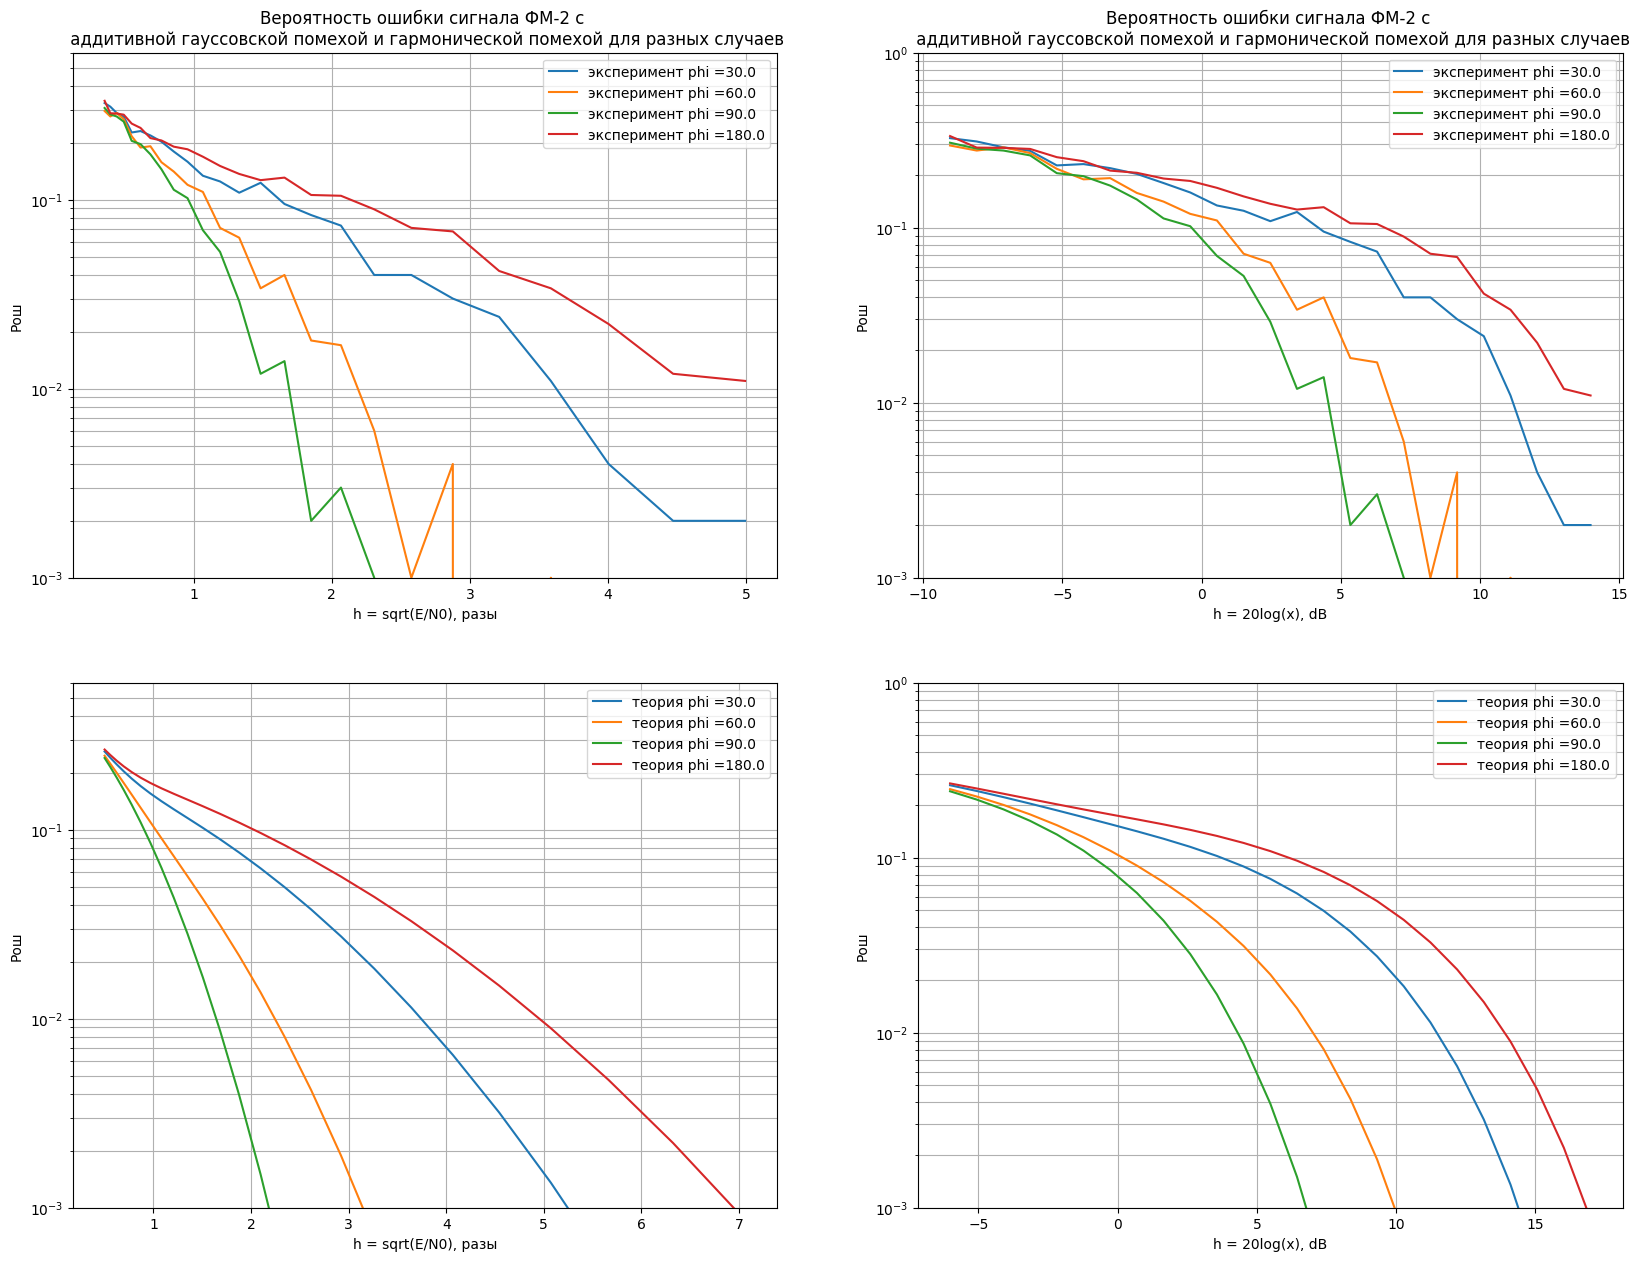

In [899]:
def monte_carlo_u(Pn):
    Perr = []
    for n_db in Pn:
        u2 = wgn_channel(s_fm2, interf_sig = s_fm2_interf, power = n_db)
        (q, us, n) = corr_receiver(u2, t, T)
        Perr.append(calc_err(q.reshape(-1,n), x))
    return np.array(Perr)

phi_range = [30,60,90,180]

fig6, ax6 = plt.subplots(2, 2, figsize = (20, 15))

ax6[0, 0].set_xlabel('h = sqrt(E/N0), разы')
ax6[0, 0].set_ylabel('Pош')
ax6[0, 0].grid(True, which = 'both', axis = 'both')
ax6[0, 0].set_ylim(1e-3, 0.6)

ax6[0, 0].set_title('Вероятность ошибки сигнала ФМ-2 с \n аддитивной гауссовской помехой и гармонической помехой для разных случаев')
ax6[0, 1].set_title('Вероятность ошибки сигнала ФМ-2 с \n аддитивной гауссовской помехой и гармонической помехой для разных случаев')
ax6[0, 1].set_xlabel('h = 20log(x), dB')
ax6[0, 1].set_ylabel('Pош')
ax6[0, 1].grid(True, which = 'both', axis = 'both')
ax6[0, 1].set_ylim(1e-3, 1)

for phi_i in phi_range:    
    # s_fm2 = to_fm2(s, t, h = 1)
    s_fm2_interf = to_fm2(1, t, ph0 = np.radians(phi_i), h = 1, U0 = 1/np.sqrt(2))
    u_tmp = wgn_channel(s_fm2, interf_sig = s_fm2_interf)
    Pn = np.var(u_tmp - s_fm2); N0 = Pn*dt
    h2 = Es/(noise_pwr*dt)
    Perr_fm2_exp = monte_carlo_u(noise_pwr_db)
    ax6[0, 0].semilogy(np.sqrt(0.5*h2),Perr_fm2_exp, label='эксперимент phi =%3.1f' %phi_i)
    ax6[0, 1].semilogy(20*np.log10(np.sqrt(0.5*h2)),Perr_fm2_exp, label='эксперимент phi =%3.1f' %phi_i)

ax6[0, 1].legend()
ax6[0, 0].legend()


for phi_i in phi_range:
    Perr_fm2 = (1/2*(1-norm.cdf(np.sqrt(2*h2)*(1 - np.sqrt(2)/2*np.cos(np.radians(phi_i))))) + 
            1/2*(1-norm.cdf(np.sqrt(2*h2)*(1 + np.sqrt(2)/2*np.cos(np.radians(phi_i))))))    
    ax6[1, 1].semilogy(20*np.log10(np.sqrt(h2)),Perr_fm2, label='теория phi =%3.1f' %phi_i)
    ax6[1, 0].semilogy(np.sqrt(h2), Perr_fm2, label='теория phi =%3.1f' %phi_i)

ax6[1, 0].set_xlabel('h = sqrt(E/N0), разы')
ax6[1, 0].set_ylabel('Pош')
ax6[1, 0].grid(True, which = 'both', axis = 'both')
ax6[1, 0].set_ylim(1e-3, 0.6)

ax6[1, 1].set_xlabel('h = 20log(x), dB')
ax6[1, 1].set_ylabel('Pош')
ax6[1, 1].grid(True, which = 'both', axis = 'both')
ax6[1, 1].set_ylim(1e-3, 1)
ax6[1, 1].legend()
ax6[1, 0].legend()


#### Пункт 11
Модифицируем гауссовский канал связи, добавив в него случайную составляющую коэффициента передачи в канале связи, распределеного по закону Релея.


In [900]:
def get_rayleigh(x, sigma):
    ns = int(fs*T)
    n_sig = len(x.reshape(-1, ns))
    mu = np.random.rayleigh(sigma, n_sig)
    mu_matrix = np.tile(mu, (ns, 1))
    s_rayl = mu_matrix.T.reshape(-1)
    return s_rayl

AmplRayl = get_rayleigh(s_fm2, sigma = 5)

U_rayleigh = wgn_channel(s_fm2, a = AmplRayl, power = -100)



Noise power is  9.964188794583156e-11


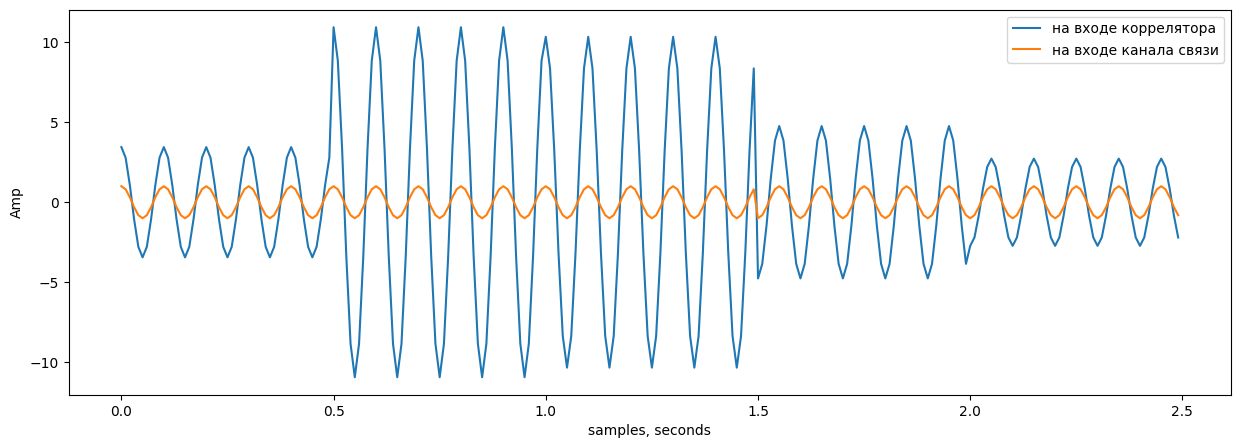

In [901]:
fig4,ax4 = plt.subplots(figsize = (15, 5))
ax4.plot(t[:250], U_rayleigh[:250], label= 'на входе коррелятора')
ax4.plot(t[:250], s_fm2[:250], label= 'на входе канала связи')
ax4.set_xlabel('samples, seconds')
ax4.set_ylabel('Amp')
ax4.legend();

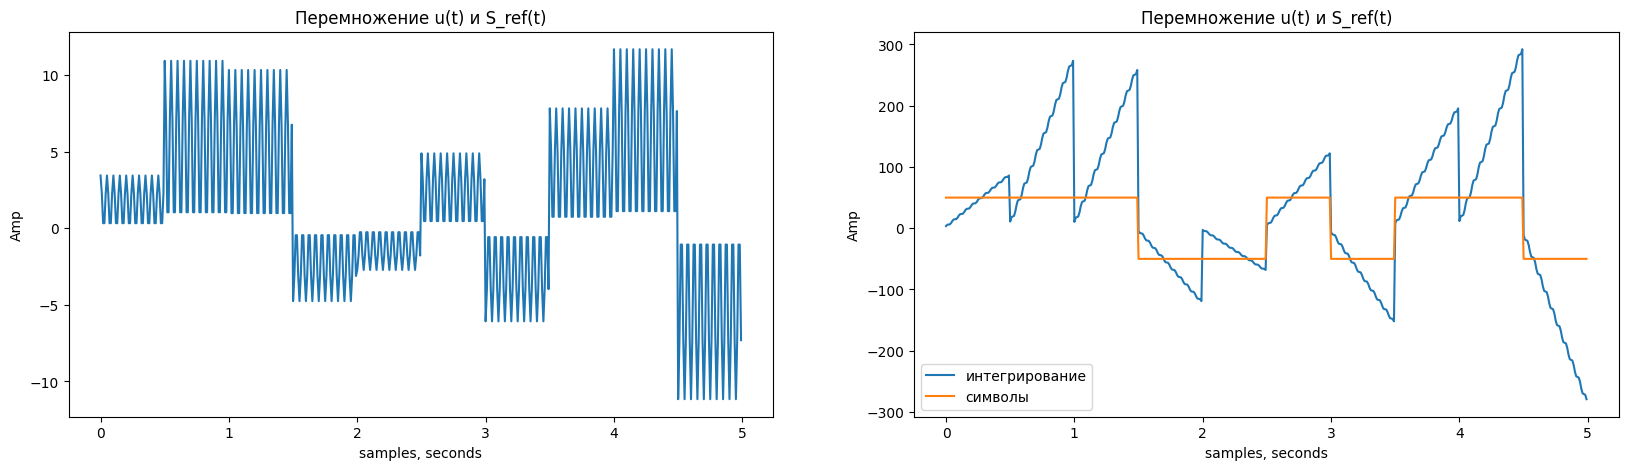

In [902]:
(q_r, us_r, n_r) = corr_receiver(U_rayleigh, t, T)

fig11, ax11 = plt.subplots(1, 2, figsize=(20, 5))

ax11[0].plot(t[:500], us_r[:500], label = 'перемножение')

ax11[0].set_xlabel('samples, seconds')
ax11[0].set_ylabel('Amp')
ax11[0].set_title('Перемножение u(t) и S_ref(t)')

ax11[1].plot(t[:500], q_r[:500], label= 'интегрирование')

ax11[1].set_xlabel('samples, seconds')
ax11[1].set_ylabel('Amp')
ax11[1].set_title('Перемножение u(t) и S_ref(t)')
ax11[1].plot(t[:500], n_r*s[:500], label= 'символы')
ax11[1].legend();

In [903]:
biterr = calc_err(q_r.reshape(-1,n), x)
print('biterror is ', biterr)

biterror is  0.0


#### Пункт 12
Отобразим на одном графике кривые помехоустойчивости для гауссовского канала с постоянными параметрами и со случайным коэффициентом передачи (Релеевские замирания). Объясните полученный результат.

In [904]:
def monte_carlo_rayleigh(Pn, sigma = 5):
    Perr = []
    for n_db in Pn:
        AmplRayl = get_rayleigh(s_fm2, sigma = sigma)
        U_rayleigh = wgn_channel(s_fm2, n_db, a = AmplRayl)
        (q, us, n) = corr_receiver(U_rayleigh, t, T)
        Perr.append(calc_err(q.reshape(-1,n), x))
    return np.array(Perr)
## посчитать отношение с\ш и усреднить его

Perr_fm2_rall = ( 1/(4*h2) )

Perr_fm2_exp_rall = monte_carlo_rayleigh(h2)


Noise power is  97621.93941423918
Noise power is  9934.926932455788
Noise power is  1621.2329128682422
Noise power is  373.9843931055528
Noise power is  115.61944592089299
Noise power is  45.54866205315959
Noise power is  21.19285857638347
Noise power is  11.634009193839551
Noise power is  7.160023622068143
Noise power is  4.813462696510763
Noise power is  3.5461342146721675
Noise power is  2.754671831080414
Noise power is  2.2639282938153267
Noise power is  1.9339602070506123
Noise power is  1.6671596087830634
Noise power is  1.5153971885842605
Noise power is  1.3996245487406258
Noise power is  1.3173713711849366
Noise power is  1.2281176327658645
Noise power is  1.196339266331783
Noise power is  1.1406952729143327
Noise power is  1.1196538887709473
Noise power is  1.088900461386797
Noise power is  1.0738529231321918
Noise power is  1.0588621341116553


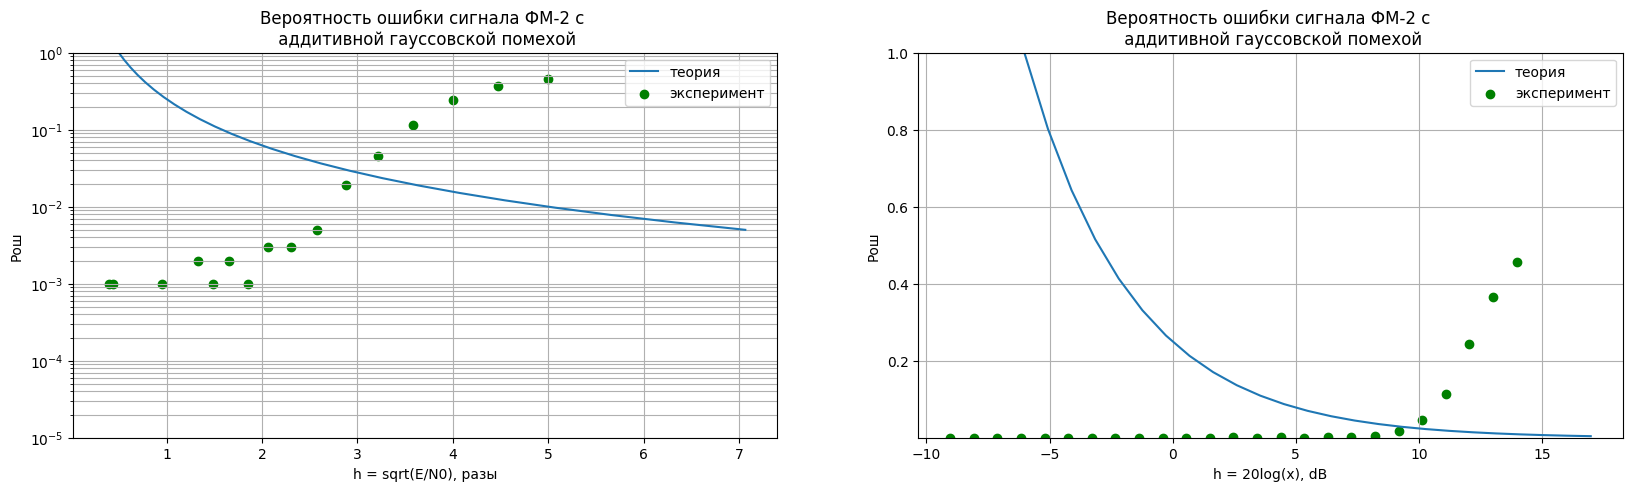

In [905]:
fig3, ax3 = plt.subplots(1, 2, figsize = (20, 5))

ax3[0].plot(np.sqrt(h2),(Perr_fm2_rall), label='теория')
ax3[0].scatter(np.sqrt(0.5*h2),Perr_fm2_exp_rall, label='эксперимент', color = "green")

ax3[0].set_title('Вероятность ошибки сигнала ФМ-2 с \n аддитивной гауссовской помехой')
ax3[0].set_xlabel('h = sqrt(E/N0), разы')
ax3[0].set_ylabel('Pош')
ax3[0].grid(True, which = 'both', axis = 'both')
ax3[0].set_ylim(1e-5,1)
ax3[0].set_yscale('log')
# ax3[0].set_ylim(1e-5,1)
#ax3[0].set_xlim(0,4)
ax3[0].legend()

ax3[1].plot(20*np.log10(np.sqrt(h2)),Perr_fm2_rall, label='теория')
ax3[1].scatter(20*np.log10(np.sqrt(0.5*h2)),Perr_fm2_exp_rall, label='эксперимент', color = "green")

ax3[1].set_xlabel('h = 20log(x), dB')
ax3[1].set_title('Вероятность ошибки сигнала ФМ-2 с \n аддитивной гауссовской помехой')
ax3[1].set_ylabel('Pош')
ax3[1].grid(True, which = 'both', axis = 'both')
ax3[1].set_ylim(1e-3, 1)
ax3[1].legend();


## Вариант 2 - ФМ4 со сдвигом


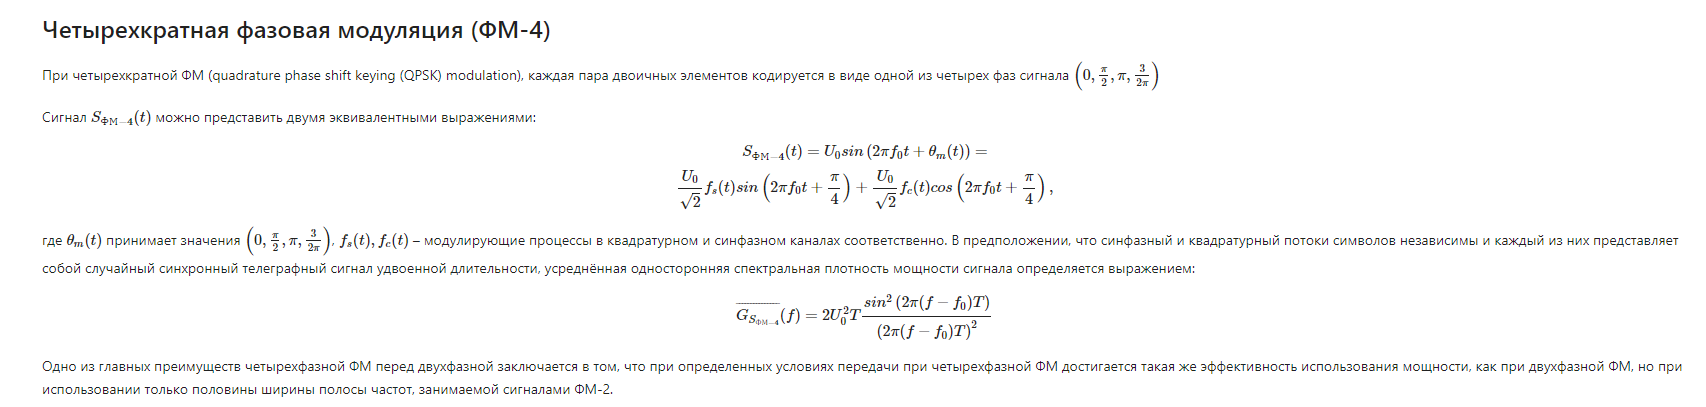

In [906]:
def to_fm4_shift(s, c, t, f0 = f0, U0 = 1.0):
    # знаем, что 2 000 выборок нагенерили. В одной квадратуре 1 000 выборок исходного телеграфного сигнала.
    shift = int((len(s)/1000)/2)
    
    return (U0/np.sqrt(2)*s*np.sin(2*np.pi*f0*t + np.pi/4) + 
           np.roll(U0/np.sqrt(2)*c*np.sin(2*np.pi*f0*t + np.pi/4), shift)  )

Воспользуемся ранее проведенными расчетами телеграфного сигнала и из него софрмируем ФМ4 сигнал.

In [907]:
x_2, numbers_2 = get_telegraph_signal(number = 2000)
(s_2, t_2, _, _) = to_samples(x, f0 = f0)

Number of samples per simbos is  50


In [908]:
s_fm4_shift = to_fm4_shift(s_2[::2],s_2[1::2], t[:int(len(t)/2)])

Noise power is  0.9913843020614193


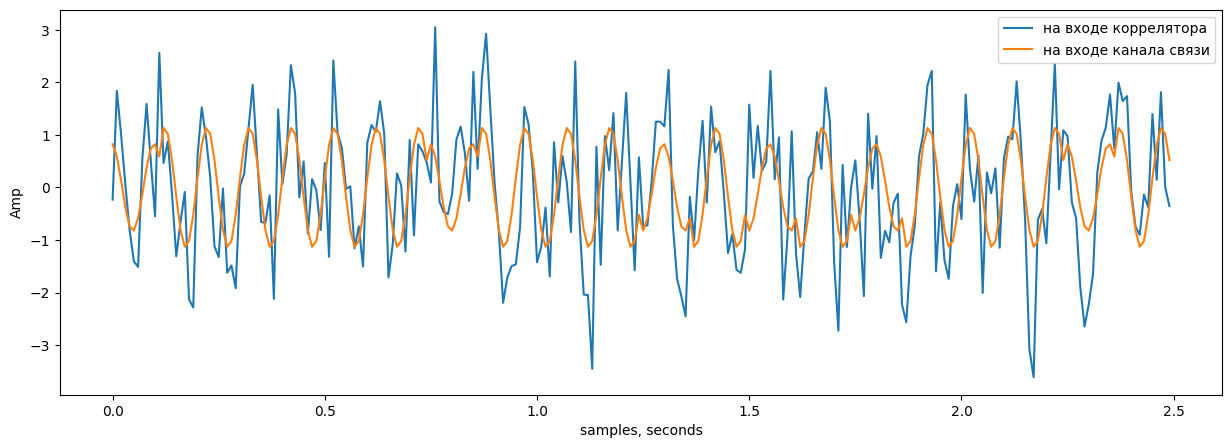

In [909]:
fm4_chan = wgn_channel(s_fm4_shift,0)

fig1,ax1 = plt.subplots(figsize = (15, 5))
ax1.plot(t[:250], fm4_chan[:250], label= 'на входе коррелятора')
ax1.plot(t[:250], s_fm4_shift[:250], label= 'на входе канала связи')
ax1.set_xlabel('samples, seconds')
ax1.set_ylabel('Amp')
ax1.legend();